In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

<br><br><br><br><br>

# 1. 데이터셋 구성

## load data

- 32x32 (각 픽셀은 0-255사이의 정숫값을 가짐)
- train : 50,000장 / test : 10,000장

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

In [3]:
print(train_x.shape, test_x.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [4]:
print("max pixel:", train_x.max(), "\ min pixel:", train_x.min())

max pixel: 255 \ min pixel: 0


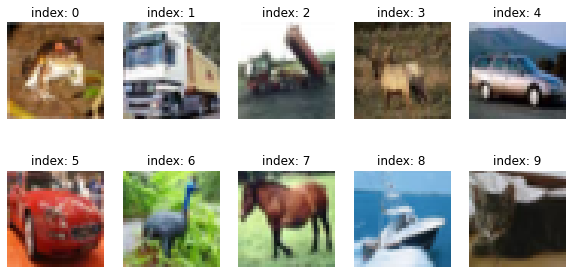

In [5]:
# 10개 이미지 확인
plt.figure(figsize=(10, 5))  # 이미지의 전체 프레임 크기 결정

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

## train_x 정규화

In [6]:
# 정규화 [-1, 1]
train_x = (train_x - 127.5)/127.5
print("max pixel:", train_x.max(), "\ min pixel:", train_x.min())

max pixel: 1.0 \ min pixel: -1.0


## train data 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

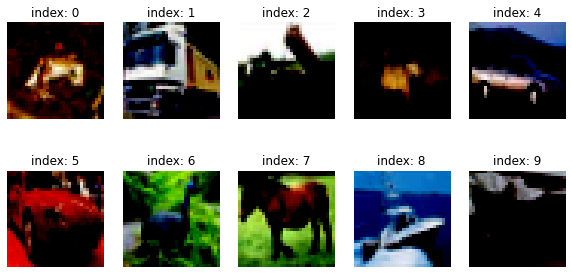

In [7]:
# 10개 이미지 확인
plt.figure(figsize=(10, 5))  # 이미지의 전체 프레임 크기 결정

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

imshow()는 음수는 표현이 안되기 때문에, [-1,1]의 값을 다시 [0,1]로 변환시켜주는 작업이 필요하다.

## 미니배치 데이터셋 구성

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<br><br><br><br><br>

# 2. 생성자 모델 구현

(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수 생성

In [9]:
def make_generator_model():
    # start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [10]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [11]:
noise = tf.random.normal([1, 100])  # 정규분포 난수 생성
generated_image = generator(noise, training=False)
print(generated_image.shape)

(1, 32, 32, 3)


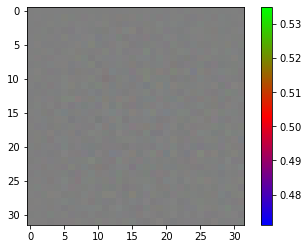

In [12]:
rgb_img = (generated_image[0, :, :, :]+1)/2

# 이미지 시각화
plt.imshow(rgb_img, cmap='brg')
plt.colorbar()
plt.show()

<br><br><br><br><br>

# 3. 판별자 모델 구현
'진짜라고 판단하는 정도' 값을 출력

In [13]:
def make_discriminator_model():
    # start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model

In [14]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [15]:
# STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00116175]], dtype=float32)>

<br><br><br><br><br>

# 4. 손실함수, 최적화 함수 구현

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


# generator_loss : 1에 가까워지길 바라므로, tf.ones_like과 비교
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


# discriminator_loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [17]:
# 생성자와 판별자를 최적화하는 optimizer 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

<br><br><br><br><br>

# 5. 훈련과정 상세 기능 구현
- train_step() : 한 단계 학습
- generate_and_save_images() : 샘플이미지 생성 및 저장
- draw_train_history() : 학습과정(loss, accuracy) 시각화
- checkpoint : 모델 저장

In [18]:
# 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것
# 샘플은 한 번에 16장을 생성
# 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 한다.
# 즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만듬
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [19]:
# 1개 미니배치의 훈련 과정을 처리하는 함수
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generated_images 생성
        generated_images = generator(noise, training=True)
        
        # discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    # gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # model 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [20]:
"""
# 정규화 [-1, 1]
train_x = (train_x - 127.5)/127.5
print("max pixel:", train_x.max(), "\ min pixel:", train_x.min())
"""
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(os.getenv('HOME'), epoch, it))
    plt.show()

In [21]:
# 훈련 epoch마다 생성자/판별자의 loss 및
# 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를
# 그래프로 시각화하는 함수

#train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy
# 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가
# 매 epoch마다 시각화하는 함수


rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [22]:
# training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정
checkpoint_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer = discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

<br><br><br><br><br>

# 6. 학습과정 진행

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.  
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [23]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {
        'gen_loss': [],
        'disc_loss': [],
        'real_accuracy': [],
        'fake_accuracy': []
    }
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print(f'Epoch {epoch+1} | iter {it+1}')
                print(f'Time for epoch {epoch+1} : {int(time.time()-epoch_start)} sec')
        
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f'Time for training : {int(time.time()-start)}')
        
        draw_train_history(history, epoch)

In [24]:
save_every = 5
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

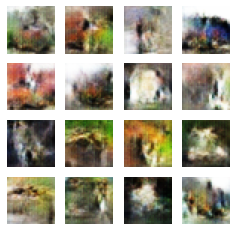

Time for training : 3505


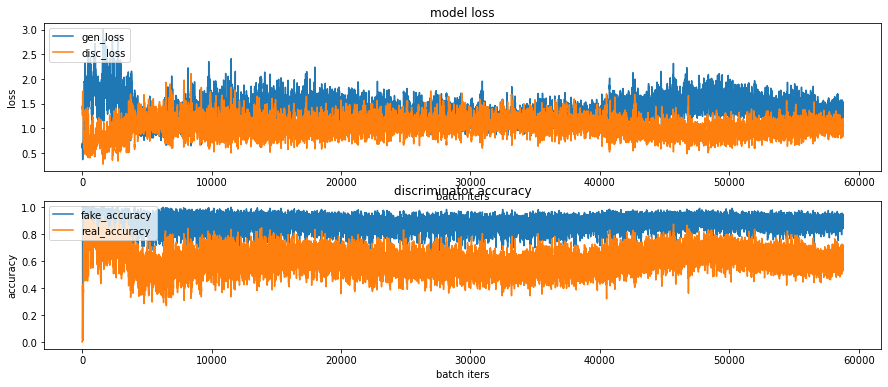

CPU times: user 58min 23s, sys: 2min 15s, total: 1h 39s
Wall time: 58min 27s


In [25]:
%%time
train(train_dataset, EPOCHS, save_every)

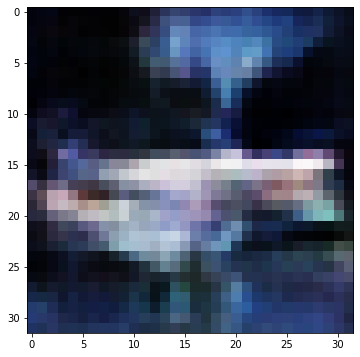

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 모델이 정상 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것

checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.

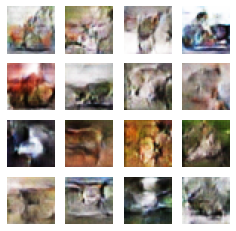

Time for training : 3505


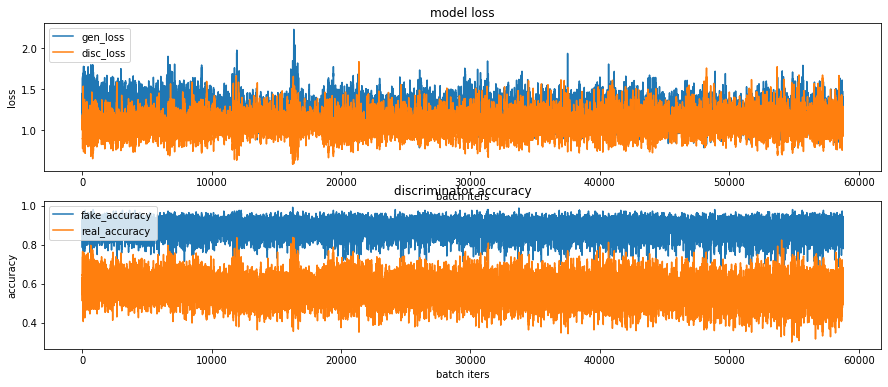

CPU times: user 58min 50s, sys: 2min 2s, total: 1h 52s
Wall time: 58min 27s


In [27]:
%%time
train(train_dataset, EPOCHS, save_every)

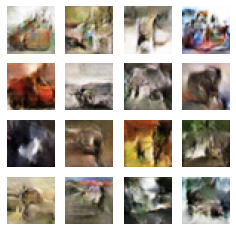

Time for training : 3488


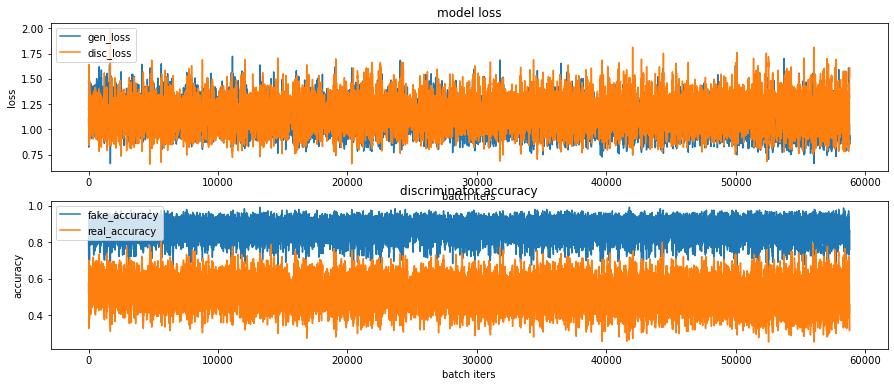

CPU times: user 58min 35s, sys: 2min 1s, total: 1h 36s
Wall time: 58min 10s


In [31]:
%%time
train(train_dataset, EPOCHS, save_every)

<br><br><br><br><br>

# 학습과정 시각화하기

In [30]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 ssac14 ssac14 3049597  2월 25 02:33 /home/ssac14/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


<br><br><br><br><br>

# 7. GAN 훈련 과정 개선

STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.  
모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.  

문제점
- epoch를 늘렸더니 이미지가 뚜렷해지면서 점차 cifar10이미지와 비슷해져갔고, loss도 줄어갔다.


<br><br><br><br><br>

1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.  
오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.  
  
  
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.  
gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.  
  
  
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.  
제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.

# 회고
## 이번 프로젝트에서 어려웠던 점


## 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점


## 루브릭 평가 지표를 맞추기 위해 시도한 것들


## 만약에 루브릭 평가관련 지표를 달성하지 못했을 때, 이유에 관한 추정


## 자기다짐
